# Algorithm Outline/Plan
### practice work on the algorithm

In [1]:
import numpy as np
import heartpy as hp
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
from scipy.signal import find_peaks, argrelextrema
from scipy import integrate


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the datasets
mat = scipy.io.loadmat(r"C:\Users\nitar\OneDrive - Virginia Tech\BMES 4015\Example ML Algorithms from Lit Reviews\T2TGAN - data\part_1.mat")

In [3]:
records = [record for record in mat['p'][0]]

'''
for each record:
3 types
r[0][i]

The sampling frequency (fs) is the number of samples per second:
1: PPG signal, FS=125Hz; photoplethysmograph from fingertip
2: ABP signal, FS=125Hz; invasive arterial blood pressure (mmHg)
3: ECG signal, FS=125Hz; electrocardiogram from channel II

Ex for records[0][i]: 125 samples/sec ; 61000 samples = 488 sec or ~8 min
'''
#print(len(records[i][j]))

'\nfor each record:\n3 types\nr[0][i]\n\nThe sampling frequency (fs) is the number of samples per second:\n1: PPG signal, FS=125Hz; photoplethysmograph from fingertip\n2: ABP signal, FS=125Hz; invasive arterial blood pressure (mmHg)\n3: ECG signal, FS=125Hz; electrocardiogram from channel II\n\nEx for records[0][i]: 125 samples/sec ; 61000 samples = 488 sec or ~8 min\n'

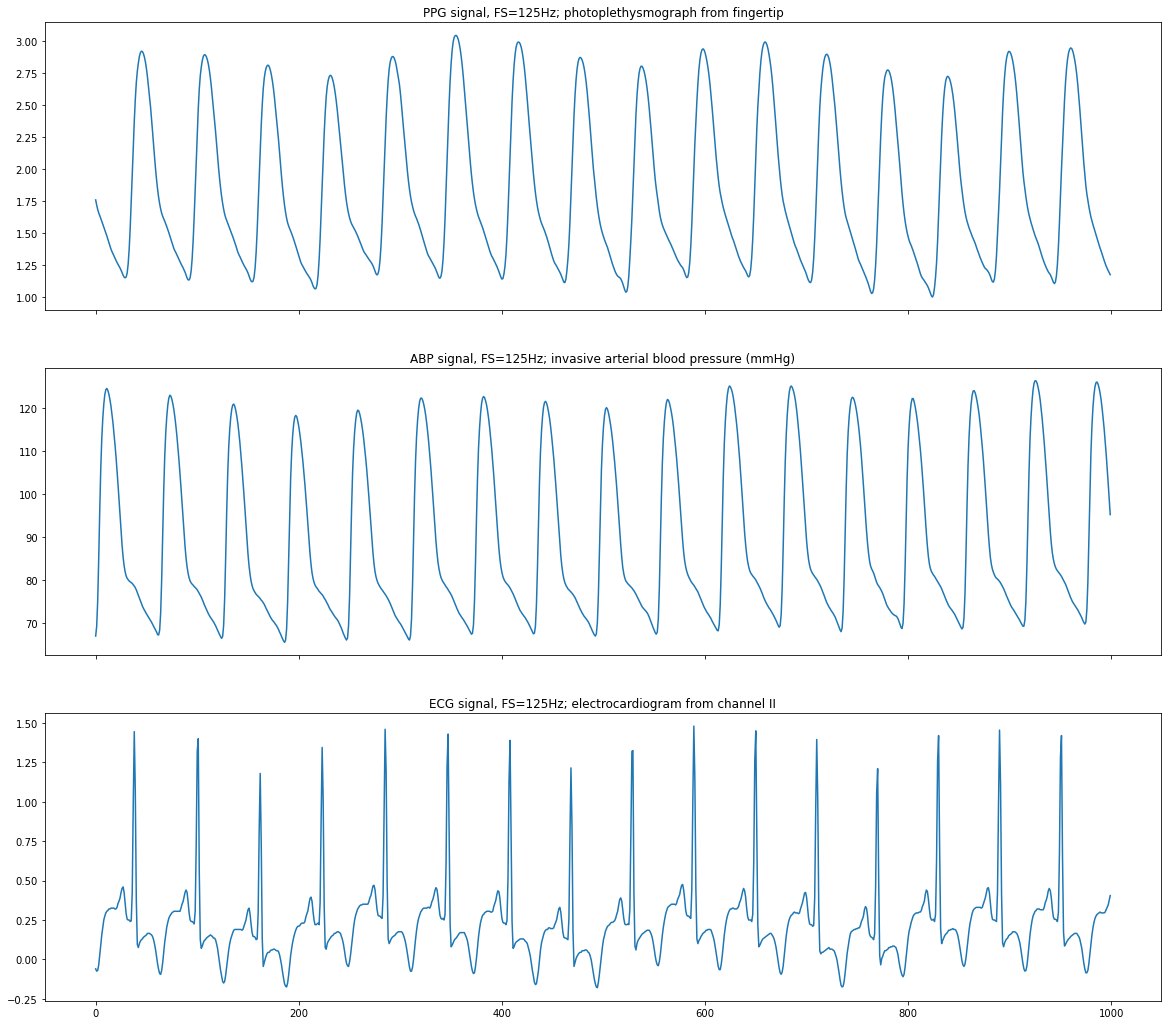

In [4]:
# Create three subplots 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,sharex=True,figsize=(20,18))
# plotting the first 8 seconds of the first record
ax1.plot(records[0][0][:1000])
ax1.title.set_text('PPG signal, FS=125Hz; photoplethysmograph from fingertip')
ax2.plot(records[0][1][:1000])
ax2.title.set_text('ABP signal, FS=125Hz; invasive arterial blood pressure (mmHg)')
ax3.plot(records[0][2][:1000])
ax3.title.set_text('ECG signal, FS=125Hz; electrocardiogram from channel II')

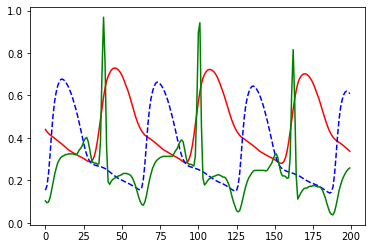

In [5]:
plt.plot(preprocessing.minmax_scale(records[0][0],feature_range=(0, 1))[:200],'r')
plt.plot(preprocessing.minmax_scale(records[0][1],feature_range=(0, 1))[:200],'b--')
plt.plot(preprocessing.minmax_scale(records[0][2],feature_range=(0, 1))[:200],'g')

In [6]:
PPG = np.array(records[0][0])
ABP = np.array(records[0][1])
ECG = np.array(records[0][2])

## Data Preprocessing

## ECG

In [7]:
ECG_norm = preprocessing.minmax_scale(records[0][2],feature_range=(0, 1))

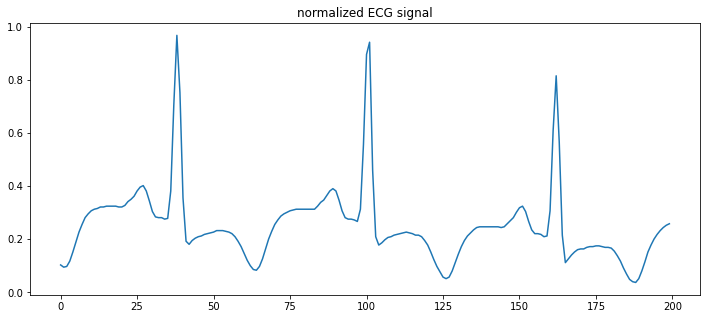

In [89]:
plt.figure(figsize=(12,5))
plt.title('normalized ECG signal')
plt.plot(ECG_norm[:200])
plt.show()
plt.show()

In [81]:
peak = find_peaks(ECG_norm, height=0.01, prominence=0.01)
r_peak = []
p_peak = []
t_peak = []
for i in range(len(peak[0])-2):
    if i == 0:
        p_peak.append(peak[0][i])
    else:
        if ECG_norm[peak[0][i]] > 0.7:
            r_peak.append(peak[0][i])
            if ECG_norm[peak[0][i+1]] < 0.7:
                p_peak.append(peak[0][i+2])
            if ECG_norm[peak[0][i+2]] < 0.7:
                t_peak.append(peak[0][i+1])
all_peaks = sorted([*set(r_peak + p_peak + t_peak)])

choose index of first peak;
if the peak is an r peak,
choose range between r peak and previous peak (p)
find the min value and add to q
index min values and add to q idxs;
then choose range between r peak and next peak (t)
find the min value and add to s
index min values and add to s idxs;

In [92]:
q_pt = []
s_pt = []
q_idx = []
s_idx = []
for i in range(len(all_peaks)-1):
    if ECG_norm[all_peaks[i]] > 0.7:
        ptp1 = ECG_norm[all_peaks[i-1]:all_peaks[i]]
        q_pt.append(min(ptp1))
        q_idx.append((np.where(ptp1 == min(ptp1))[0][0]+all_peaks[i-1]))
        ptp2 = ECG_norm[all_peaks[i]:all_peaks[i+1]]
        s_pt.append(min(ptp2))
        s_idx.append((np.where(ptp2 == min(ptp2))[0][0]+all_peaks[i]))

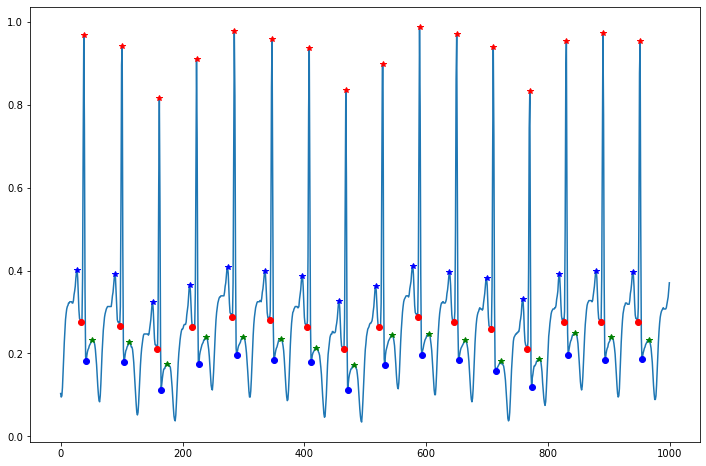

In [87]:
plt.figure(figsize=(12,8))
plt.plot(ECG_norm[:1000])
plt.plot(r_peak[:16], ECG_norm[r_peak[:16]],'r*')
plt.plot(p_peak[:16], ECG_norm[p_peak[:16]],'b*')
plt.plot(t_peak[:16], ECG_norm[t_peak[:16]],'g*')
plt.plot(q_idx[:16], q_pt[:16],'ro')
plt.plot(s_idx[:16], s_pt[:16],'bo')
plt.show()

In [95]:
data = ()
data = data + ((p_peak, ECG_norm[p_peak]),)
data = data + ((r_peak, ECG_norm[r_peak]),)
data = data + ((t_peak, ECG_norm[t_peak]),)
data = data + ((q_idx, q_pt),)
data = data + ((s_idx, s_pt),)

In [96]:
df1 = pd.DataFrame(columns=['p_peak_idx','p_peak',
                            'r_peak_idx','r_peak',
                            't_peak_idx','t_peak',
                            'q_idx','q_pt',
                            's_idx','s_pt'
                          ])
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   p_peak_idx  0 non-null      object
 1   p_peak      0 non-null      object
 2   r_peak_idx  0 non-null      object
 3   r_peak      0 non-null      object
 4   t_peak_idx  0 non-null      object
 5   t_peak      0 non-null      object
 6   q_idx       0 non-null      object
 7   q_pt        0 non-null      object
 8   s_idx       0 non-null      object
 9   s_pt        0 non-null      object
dtypes: object(10)
memory usage: 0.0+ bytes


In [97]:
for i in range(len(data[0][0])):
    row_vals = []
    row_vals.extend([data[0][0][i],data[0][1][i]])
    for j in range(1,5):
        idx_index = list(x for x in data[j][0] if data[0][0][i] <= x <= data[0][0][i+1])
        if bool(idx_index) == True:
            val_index = np.where(np.asarray(data[j][0])==idx_index[0])
            val = data[j][1][val_index[0][0]]
            row_vals.extend([idx_index[0],val])
        else:
            row_vals.extend([np.nan,np.nan])
    
    # adding the row to the dataframe
    df1.loc[i] = row_vals

In [101]:
df1 = df1.dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 0 to 993
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   p_peak_idx  990 non-null    float64
 1   p_peak      990 non-null    float64
 2   r_peak_idx  990 non-null    float64
 3   r_peak      990 non-null    float64
 4   t_peak_idx  990 non-null    float64
 5   t_peak      990 non-null    float64
 6   q_idx       990 non-null    float64
 7   q_pt        990 non-null    float64
 8   s_idx       990 non-null    float64
 9   s_pt        990 non-null    float64
dtypes: float64(10)
memory usage: 85.1 KB


In [ ]:
# DEFINITIONS

def delta_time(idx_a, idx_b):
    return (idx_b-idx_a)/125

def slope(val_a, val_b, idx_a, idx_b): 
    return (val_b-val_a)/delta_time(idx_a,idx_b) 

def auc(data, idx_a, idx_b):
    x = data[int(idx_a):int(idx_b+1)]
    y = range(0, int(idx_b-idx_a)+1)
    return abs(np.trapz(y=y, x=x))

In [ ]:
# QRS_time: Time for a full QRS wave (ECG)
df['QRS_time'] = df.apply(lambda row : delta_time(row['q_idx'],row['s_idx']), axis = 1)  

In [ ]:
# RP_time: Time from P peak to R peak (ECG)
df['RP_time'] = df.apply(lambda row : delta_time(row['p_peak_idx'],row['r_peak_idx']), axis = 1)  

In [ ]:
# RT_time: Time from R peak to T peak (ECG)
df['RT_time'] = df.apply(lambda row : delta_time(row['r_peak_idx'],row['t_peak_idx']), axis = 1)  

In [ ]:
# PQ_time: Time from P peak to Q valley (ECG)
df['PQ_time'] = df.apply(lambda row : delta_time(row['p_peak_idx'],row['q_idx']), axis = 1)  

In [ ]:
# ST_time: Time from S valley to T peak (ECG)
df['ST_time'] = df.apply(lambda row : delta_time(row['s_idx'],row['t_peak_idx']), axis = 1)  

In [ ]:
# PT_time: Time from P peak to T peak (ECG)
df['PT_time'] = df.apply(lambda row : delta_time(row['p_peak_idx'],row['t_peak_idx']), axis = 1)  

In [ ]:
# P_amp: P peak amplitude
df['P_amp'] = df.apply(lambda row : row['p_peak'], axis = 1) 

In [ ]:
# R_amp: R peak amplitude
df['R_amp'] = df.apply(lambda row : row['r_peak'], axis = 1) 

In [ ]:
# T_amp: T peak amplitude
df['T_amp'] = df.apply(lambda row : row['t_peak'], axis = 1) 

In [ ]:
# RT_ratio: T_amp/R_amp
df['RT_ratio'] = df.apply(lambda row : row['t_peak']/row['r_peak'], axis = 1) 

In [ ]:
# RP_diff: R_amp - P_amp
df['RP_diff'] = df.apply(lambda row :row['r_peak']-row['p_peak'], axis = 1) 

In [ ]:
''' PTT Variables '''
# PTT_p: Time from R peak of ECG to systolic peak of PPG
#PTT_d: Time from R peak of ECG to max slope point of PPG (dPPG)
#PTT_f: Time from R peak of ECG to foot of PPG signal

## PPG
### 1. Noise Removal
Fast Fourier Transform to convert from time domain into the frequency domain. Let x[n], 0<=n<= N-1, represent the PPG, and the FTT of x[n] is denoted as X[k], 0<=k<=N-1. The frquency components that are lower than 0 Hz or higher than 8 Hz are removed (to reduce noise and baseline wandering) by the following:  Xr[k] = X[k] where k>= 8; 0 otherwise <br/>
Inverse FFT (IFFT) restored the PPG data to the time domain

In [ ]:
# The data above has already been processed, so we are skipping this step for now.

### 2. Normalization - 1st/2nd Derivative Calculations
Every segment is normalized (between [0 1] using x'=(x-Xm)/(XM-Xm) where x is the data point, Xm is the min, and XM is the max.<br/>
The 1st (dPPG) and 2nd (sdPPG) derivatives are then calculated.

In [ ]:
# norm
PPG_norm = preprocessing.minmax_scale(records[0][0],feature_range=(0, 1))

# 1st derivative
PPG_d = np.gradient(PPG_norm)

# 2nd derivative
PPG_sd = np.gradient(PPG_d)

In [ ]:
# Create three subplots 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,sharex=True,figsize=(20,18))
# plotting the first 8 seconds of the first record
ax1.plot(PPG_norm[:1000])
ax1.title.set_text('normalized PPG signal')
ax2.plot(PPG_d[:1000])
ax2.title.set_text('1st derivative PPG (dPPG)')
ax3.plot(PPG_sd[:1000])
ax3.title.set_text('2nd derivative PPG (sdPPG)')

### 3. Feature Point Detection
https://github.com/paulvangentcom/heartrate_analysis_python
<br/>The following points should be labeled/extracted from the PPG/dPPG/sdPPG:<br/>
    a. systolic peaks of PPG<br/>
    b. onset and offset valley points of PPG by finding the min between 2 consecutive systolic peaks<br/>
    c. locations with maximal and minimal slope values of PPG and dPPG by computing the gradients of the valley points<br/>
    d. dicrotic notch points from secondary peaks of sdPPG contour

In [ ]:
# running the PPG peak detection analysis 
wd1, m1 = hp.process(PPG_norm, sample_rate = 125) # full array
hp.visualizeutils.plotter(wd1, m1, figsize=(12,4))
wd2, m2 = hp.process(PPG_norm[8000:10000], sample_rate = 125) # full array
hp.visualizeutils.plotter(wd2, m2, figsize=(12,4))
wd_d1, m_d1 = hp.process(PPG_d, sample_rate = 125) # full array
hp.visualizeutils.plotter(wd_d1, m_d1, figsize=(12,4))
wd_d2, m_d2 = hp.process(PPG_d[8000:10000], sample_rate = 125) # full array
hp.visualizeutils.plotter(wd_d2, m_d2, figsize=(12,4))
wd_sd1, m_sd1 = hp.process(PPG_sd, sample_rate = 125) # full array
hp.visualizeutils.plotter(wd_sd1, m_sd1, figsize=(12,4))
wd_sd2, m_sd2 = hp.process(PPG_sd[8000:9000], sample_rate = 125) # full array
hp.visualizeutils.plotter(wd_sd2, m_sd2, figsize=(12,4))

In [ ]:
'''
Tuple: (([systolic_peak_idx],[systolic_peak]),
        ([valley_point_idx],[valley_point]),
        ([slopeval_ppg_idx],[slopeval_ppg]),
        ([slopeval_dppg_idx],[slopeval_dppg]),
        ([dicrotic_notch_idx],[dicrotic_notch]))
Indexing rules - data[i][j][k]
where i = data type, j = 0 (index) or 1 (value), and k is in range(len(data type)).
       
       
Dict: {
systolic_peak  : {vals: [],
                  ids": []},
valley_point   : {vals: [],
                  ids": []},
slopeval_ppg   : {vals: [],
                  ids": []}, 
slopeval_dppg  : {vals: [],
                  ids": []},
dicrotic_notch : {vals: [],
                  ids": []}                
}

'''

In [ ]:
# (a) systolic peaks
systolic_peak_idx = wd1['peaklist'] # array of peak indices
systolic_peak = wd1['ybeat'] # array of peak values

In [ ]:
# (b1) valley points for PPG
ppg_valley_point_idx = [] # array of valley point indices
ppg_valley_point = [] # array of valley point values
for i in range(len(systolic_peak)-1):
    if i == 0:
        p1 = 0 # beginning of data
        p2 = systolic_peak_idx[i] # index of 1st peak
        ptp = PPG_norm[p1:p2]
        min_val = min(ptp)
        ppg_valley_point.append(min_val)
        min_idx = np.where(ptp == min_val)
        ppg_valley_point_idx.append(min_idx[0][0].tolist()) 
    else: 
        p1 = systolic_peak_idx[i-1] # index of 1st peak
        p2 = systolic_peak_idx[i] # index of 2nd peak
        ptp = PPG_norm[p1:p2]
        min_val = min(ptp)
        ppg_valley_point.append(min_val)
        min_idx = np.where(ptp == min_val) + p1
        ppg_valley_point_idx.append(min_idx[0][0].tolist())

In [ ]:
# (b2) valley points and lowest points for dPPG
dppg_peak_idx = wd_d1['peaklist']
dppg_peak = wd_d1['ybeat']
dppg_valley_point_idx = [] # array of valley point indices
dppg_valley_point = [] # array of valley point values
dppg_dDA_point_idx = [] # array of lowest point indices
dppg_dDA_point = [] # array of lowest point value

# valley points
for i in range(len(dppg_peak_idx)-1):
    if i == 0:
        p1 = 0 # beginning of data
        p2 = dppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_d[p1:p2]
        mins = argrelextrema(ptp, np.less)
        dppg_valley_point_idx.append(mins[0][-1])
        dppg_valley_point.append(ptp[mins[0][-1]])
    else:
        p1 = dppg_peak_idx[i-1] # index of 1st peak
        p2 = dppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_d[p1:p2]
        if len(ptp) > 20:
            mins = argrelextrema(ptp, np.less)
            if ptp[mins[0][-1]] != 0:
                dppg_valley_point_idx.append(mins[0][-1] + p1)
                dppg_valley_point.append(ptp[mins[0][-1]])
            
# lowest points
for i in range(len(dppg_peak_idx)-1):
    if i == 0:
        p1 = 0 # beginning of data
        p2 = dppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_d[p1:p2]
        min_val = min(ptp)
        dppg_dDA_point.append(min_val)
        min_idx = np.where(ptp == min_val)
        dppg_dDA_point_idx.append(min_idx[0][0].tolist())
    else:
        p1 = dppg_peak_idx[i-1] # index of 1st peak
        p2 = dppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_d[p1:p2]
        min_val = min(ptp)
        dppg_dDA_point.append(min_val)
        min_idx = np.where(ptp == min_val) + p1
        dppg_dDA_point_idx.append(min_idx[0][0].tolist())

In [ ]:
# (b3) valley points and lowest points for sdPPG
sdppg_peak_idx = wd_sd1['peaklist']
sdppg_peak = wd_sd1['ybeat']
sdppg_valley_point_idx = [] # array of valley point indices
sdppg_valley_point = [] # array of valley point values
sdppg_dDA_point_idx = [] # array of lowest point indices
sdppg_dDA_point = [] # array of lowest point value

# valley points
for i in range(len(sdppg_peak_idx)-1):
    if i == 0:
        p1 = 0 # beginning of data
        p2 = sdppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_sd[p1:p2]
        mins = argrelextrema(ptp, np.less)
        sdppg_valley_point_idx.append(mins[0][-1])
        sdppg_valley_point.append(ptp[mins[0][-1]])
    else:
        p1 = sdppg_peak_idx[i-1] # index of 1st peak
        p2 = sdppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_sd[p1:p2]
        if len(ptp) > 20:
            mins = argrelextrema(ptp, np.less)
            if ptp[mins[0][-1]] != 0:
                sdppg_valley_point_idx.append(mins[0][-1] + p1)
                sdppg_valley_point.append(ptp[mins[0][-1]])
            
# lowest points
for i in range(len(sdppg_peak_idx)-1):
    if i == 0:
        p1 = 0 # beginning of data
        p2 = sdppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_sd[p1:p2]
        min_val = min(ptp)
        sdppg_dDA_point.append(min_val)
        min_idx = np.where(ptp == min_val)
        sdppg_dDA_point_idx.append(min_idx[0][0].tolist())
    else:
        p1 = sdppg_peak_idx[i-1] # index of 1st peak
        p2 = sdppg_peak_idx[i] # index of 2nd peak
        ptp = PPG_sd[p1:p2]
        min_val = min(ptp)
        sdppg_dDA_point.append(min_val)
        min_idx = np.where(ptp == min_val) + p1
        sdppg_dDA_point_idx.append(min_idx[0][0].tolist())

In [ ]:
# (c) max/min slope values 
slopeval_ppg = [PPG_norm[i] for i in wd_d1['peaklist']]
slopeval_ppg_idx = wd_d1['peaklist']
slopeval_dppg = [PPG_d[i] for i in wd_sd1['peaklist']]
slopeval_dppg_idx = wd_sd1['peaklist']

In [ ]:
# (d) dicrotic notch points
dn = scipy.signal.find_peaks(PPG_sd, distance=25)
seconday_idx = [dn[0][index] for index in range(0, len(dn[0]), 2)]
dicrotic_notch_idx = [item for item in seconday_idx if PPG_sd[item] <= 0.05]
dicrotic_notch = [PPG_norm[i] for i in dicrotic_notch_idx]

In [ ]:
##EXAMPLES FOR HELP
plt.plot(PPG_norm[:250])
plt.plot(systolic_peak_idx[:4],systolic_peak[:4],'o')
plt.plot(ppg_valley_point_idx[:4],ppg_valley_point[:4],'bo')
plt.plot(slopeval_ppg_idx[:3],slopeval_ppg[:3],'r*')
plt.plot(dicrotic_notch_idx[:4],dicrotic_notch[:4],'ro')

In [ ]:
plt.plot(PPG_d[:200])
plt.plot(slopeval_dppg_idx[0:3],slopeval_dppg[0:3],'r*')
plt.plot(dppg_valley_point_idx[0:3], dppg_valley_point[0:3],'bo')
plt.plot(dppg_dDA_point_idx[0:4],dppg_dDA_point[0:4],'o')

In [ ]:
plt.plot(PPG_sd)
plt.plot(dicrotic_notch_idx,PPG_sd[dicrotic_notch_idx],'r*')

In [ ]:
plt.plot(PPG_sd[:200])
plt.plot(sdppg_valley_point_idx[0:3], sdppg_valley_point[0:3],'bo')
plt.plot(dicrotic_notch_idx[0:4],PPG_sd[dicrotic_notch_idx[0:4]],'r*')
plt.plot(sdppg_dDA_point_idx[0:4],sdppg_dDA_point[0:4],'o')

### ABP Features

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(ABP[:3000])
plt.title('ABP signal, FS=125Hz; invasive arterial blood pressure (mmHg)')

In [ ]:
sys_idx, sys_val = scipy.signal.find_peaks(ABP,height=(100,160))
sys_val = sys_val.get('peak_heights')
# lowest points
dias_idx = []
dias_val = []
for i in range(len(sys_idx)-1):
    p1 = sys_idx[i] # index of 1st peak
    p2 = sys_idx[i+1] # index of 2nd peak
    ptp = ABP[p1:p2]
    min_val = min(ptp)
    dias_val.append(min_val)
    min_idx = np.where(ptp == min_val) + p1
    dias_idx.append(min_idx[0][0].tolist())

### 4. Data Partitioning
Each PPG data segment and its corresponding dPPG and sdPPG waves are partitioned into fragements by reserving each PPG data segment from one valley point of the PPG to the next consecutive valley point.<br/>
At this point, abnormal heart cycle may also be removed

In [ ]:
## Creating a tuple of the variable tuples following the format described above
data = ()
data = data + ((ppg_valley_point_idx, ppg_valley_point),)
data = data + ((dppg_valley_point_idx, dppg_valley_point),)
data = data + ((sdppg_valley_point_idx, sdppg_valley_point),)
data = data + ((systolic_peak_idx, systolic_peak),)
data = data + ((slopeval_ppg_idx, slopeval_ppg),)
data = data + ((slopeval_dppg_idx, slopeval_dppg),)
data = data + ((dicrotic_notch_idx, dicrotic_notch),)
data = data + ((dppg_dDA_point_idx, dppg_dDA_point),)
data = data + ((sdppg_dDA_point_idx, sdppg_dDA_point),)
data = data + ((dppg_peak_idx, dppg_peak),)
data = data + ((sdppg_peak_idx, sdppg_peak),)
data = data + ((sys_idx, sys_val),)
data = data + ((dias_idx, dias_val),)

In [ ]:
'''
Tuple: ((sample_idx,((systolic_peak_idx, systolic_peak),
                     (onset_valley_point_idx, onset_valley_point),
                     (offset_valley_point_idx, offset_valley_point),
                     (slopeval_ppg_idx, slopeval_ppg),
                     (slopeval_dppg_idx, slopeval_dppg),
                     (dicrotic_notch_idx, dicrotic_notch)
                     )
        ))
Indexing rules - data[i][j][k][l]
where i = sample #, j = 0 (sample_index) or 1 (features), k is in range(0:5) iff j=1, and l = 0 (feature_idx) or 1 (feature_val).

~~ OR ~~

Add all values to pandas dataframe where each variable is in a column
- more organization; easier visualization
- harder to manipulate and higher cost
'''

In [ ]:
# creating an empty dataframe with labelled columns
df = pd.DataFrame(columns=['onset_valley_point_idx','onset_valley_point',
                           'offset_valley_point_idx','offset_valley_point',
                           'dppg_onset_point_idx','dppg_onset_point',
                           'sdppg_onset_point_idx','sdppg_onset_point',
                           'systolic_peak_idx','systolic_peak',
                           'slopeval_ppg_idx','slopeval_ppg',
                           'slopeval_dppg_idx','slopeval_dppg',
                           'dicrotic_notch_idx','dicrotic_notch',
                           'dppg_dDA_point_idx','dppg_dDA_point',
                           'sdppg_dDA_point_idx','sdppg_dDA_point',
                           'dppg_peak_idx', 'dppg_peak',
                           'sdppg_peak_idx', 'sdppg_peak',
                           'sys_idx','sys_val',
                           'dias_idx','dias_val'                           
                          ])
df.info()

In [ ]:
'''
data[0][0] = valley_point_idx
data[0][1] = valley_point
data[1][0] = dppg_valley_point_idx
data[1][1] = dppg_valley_point
data[2][0] = sdppg_valley_point_idx
data[2][1] = sdppg_valley_point
data[3][0] = systolic_peak_idx
data[3][1] = systolic_peak
data[4][0] = slopeval_ppg_idx
data[4][1] = slopeval_ppg
data[5][0] = slopeval_dppg_idx
data[5][1] = slopeval_dppg
data[6][0] = dicrotic_notch_idx
data[6][1] = dicrotic_notch
data[7][0] = dppg_dDA_point_idx
data[7][1] = dppg_dDA_point
data[8][0] = sdppg_dDA_point_idx
data[8][1] = sdppg_dDA_point
data[9][0] = dppg_peak_idx
data[9][1] = dppg_peak
data[10][0] = sdppg_peak_idx
data[10][1] = sdppg_peak
data[11][0] = sys_idx
data[11][1] = sys_val
data[12][0] = dias_idx
data[12][1] = dias_val
'''

In [ ]:
# determining the lengths of each variable list
for i in range(0,13):
    for j in range(0,2):
        print(len(data[i][j]))

In [ ]:
# separating each full wave element into a list and then converting the list to a df row 
for i in range(len((data[0][0]))-1):
    row_vals = []
    onset_idx = data[0][0][i]
    onset_val = data[0][1][i]
    offset_idx = data[0][0][i+1]
    offset_val = data[0][1][i+1]
    row_vals.extend([onset_idx,onset_val,offset_idx,offset_val])

    for j in range(1,13):
        idx_index = list(x for x in data[j][0] if onset_idx <= x <= offset_idx)
        if bool(idx_index) == True:
            val_index = np.where(np.asarray(data[j][0])==idx_index[0])
            val = data[j][1][val_index[0][0]]
            row_vals.extend([idx_index[0],val])
        else:
            row_vals.extend([np.nan,np.nan])
    
    # adding the row to the dataframe
    df.loc[i] = row_vals

In [ ]:
# create offset values for dPPG and sdPPG
df['dppg_offset_point_idx'] = df['dppg_onset_point_idx'].shift(periods=-1)
df['dppg_offset_point'] = df['dppg_onset_point'].shift(periods=-1)
df['sdppg_offset_point_idx'] = df['sdppg_onset_point_idx'].shift(periods=-1)
df['sdppg_offset_point'] = df['sdppg_onset_point'].shift(periods=-1)

In [ ]:
df.info()
# to check the missing values, convert to a csv file
# df.to_csv('df.csv')

In [ ]:
# delete any rows that are missing values
df = df.dropna()
df.info()

## Feature Extraction - Variables & Equations
### ECG Features
QRS_time:  Time for a full QRS wave (ECG)
<br/> RP_time:   Time from P peak to R peak (ECG)
<br/> RT_time:   Time from R peak to T peak (ECG)
<br/> PQ_time:   Time from P peak to Q peak (ECG)
<br/> ST_time:   Time from S peak to T peak (ECG)
<br/> PT_time:   Time from P peak to T peak (ECG)
<br/> P_amp:     P peak amplitude
<br/> R_amp:     R peak amplitude
<br/> T_amp:     T peak amplitude
<br/> RT_ratio:  T_amp/R_amp
<br/> RP_diff:   R_amp - P_amp
<br/> PTT_p:     Time from R peak of ECG to systolic peak of PPG
<br/> PTT_d:     Time from R peak of ECG to max slope point of PPG (dPPG)
<br/> PTT_f:     Time from R peak of ECG to foot of PPG signal

### PPG Features
HR:        Heart Rate (Peak-to-Peak time --> BPM)
<br/> AS:        Ascending slope of PPG (slope from onset point to max peak)
<br/> DS:        Descending slope of PPG (slope from max peak to offset point)
<br/> S1:        Area under curve between onset and max slope point
<br/> S2:        Area under curve between max slope point and max peak
<br/> S3:        Area under curve between max peak and dicrotic notch
<br/> S4:        Area under curve between dicrotic notch and offset point
<br/> AA:        Ascending area of PPG
<br/> DA:        Descending area of PPG
<br/> PI:        Peak intensity of PPG
<br/> dPI:       Peak intensity of dPPG
<br/> sdPI:      Peak intensity of sdPPG
<br/> dVI:       Valley intensity of dPPG
<br/> sdVI:      Valley intensity of sdPPG
<br/> AID:       Intensity diff between max peak and onset point (PPG)
<br/> dAID:      Intensity diff between max peak and onset point (dPPG)
<br/> sdAID:     Intensity diff between max peak and onset point (sdPPG)
<br/> dDID:      Intensity diff between offset point and max peak (dPPG)
<br/> sdDID:     Intensity diff between offset point and max peak (sdPPG)
<br/> dRIPV:     Ratio of max peak to valley intensity (dPPG)
<br/> sdRIPV:    Ratio of max peak to valley intensity (sdPPG)
<br/> AT:        Ascending time interval of PPG
<br/> Slope_a:   Slope from max peak to dicrotic notch of PPG
<br/> NI:        Dicrotic notch intensity
<br/> AI:        Augmentation index = NI/PI
<br/> AI1:       Augmentation index 1 = (PI-NI)/PI
<br/> RSD:       Ratio of systolic to diastolic duration
<br/> RSC:       Ratio of diastolic duration to cardiac cycle
<br/> RDC:       Ratio of systolic duaration to cardiac cycle

<br/> Other features to include: Gender, Weight, Age, Activity, etc. 

### PPG Features

In [ ]:
# HR: Heart Rate (Peak-to-Peak time --> BPM)
# (idx_2 - idx_1) - no. of samples in a beat
# 125 samples/sec * 60 sec/min => samples/min / # of samples = BPM
df['HR'] = None
for i in range(len(df)-1):
    df['HR'].iloc[i] = 1*60/delta_time(df['systolic_peak_idx'].iloc[i], df['systolic_peak_idx'].iloc[i+1])

In [ ]:
# AS: Ascending slope of PPG (slope from onset point to max peak)
# (systolic peak - onset point)/(delta(time))
df['AS'] = df.apply(lambda row : slope(row['onset_valley_point'],row['systolic_peak'],row['onset_valley_point_idx'],row['systolic_peak_idx']), axis = 1)  

In [ ]:
# DS: Descending slope of PPG (slope from max peak to offset point)
# (offset point - systolic peak)/(delta(time))
df['DS'] = df.apply(lambda row : slope(row['systolic_peak'],row['offset_valley_point'],row['systolic_peak_idx'],row['offset_valley_point_idx']), axis = 1)  

In [ ]:
# S1: Area under curve between onset and max slope point
df['S1'] = df.apply(lambda row : auc(PPG_norm, row['onset_valley_point_idx'], row['slopeval_ppg_idx']), axis=1)

In [ ]:
# S2: Area under curve between max slope point and max peak
df['S2'] = df.apply(lambda row : auc(PPG_norm, row['slopeval_ppg_idx'], row['systolic_peak_idx']), axis=1)

In [ ]:
# S3: Area under curve between max peak and dicrotic notch
df['S3'] = df.apply(lambda row : auc(PPG_norm, row['systolic_peak_idx'], row['dicrotic_notch_idx']), axis=1)

In [ ]:
# S4: Area under curve between dicrotic notch and offset point
df['S4'] = df.apply(lambda row : auc(PPG_norm, row['dicrotic_notch_idx'], row['offset_valley_point_idx']), axis=1)

In [ ]:
# AA: Ascending area of PPG
df['AA'] = df.apply(lambda row: (row['S1'] + row['S2']), axis=1)

In [ ]:
# DA: Descending area of PPG
df['DA'] = df.apply(lambda row: (row['S3'] + row['S4']), axis=1)

In [ ]:
# PI: Peak intensity of PPG
df['PI'] = df.apply(lambda row : row['systolic_peak'], axis=1)

In [ ]:
# dPI: Peak intensity of dPPG
df['dPI'] = df.apply(lambda row : row['dppg_peak'], axis=1)

In [ ]:
# sdPI: Peak intensity of sdPPG
df['sdPI'] = df.apply(lambda row : row['sdppg_peak'], axis=1)

In [ ]:
# dVI: Valley intensity of dPPG
df['dVI'] = df.apply(lambda row : row['dppg_onset_point'], axis=1)

In [ ]:
# sdVI: Valley intensity of sdPPG
df['sdVI'] = df.apply(lambda row : row['sdppg_onset_point'], axis=1)

In [ ]:
# AID: Intensity diff between max peak and onset point (PPG)
df['AID'] = df.apply(lambda row: (row['systolic_peak'] - row['onset_valley_point']), axis=1)

In [ ]:
# dAID: Intensity diff between max peak and onset point (dPPG)
df['dAID'] = df.apply(lambda row: (row['dppg_peak'] - row['dppg_onset_point']), axis=1)

In [ ]:
# sdAID: Intensity diff between max peak and onset point (sdPPG)
df['sdAID'] = df.apply(lambda row: (row['sdppg_peak'] - row['sdppg_onset_point']), axis=1)

In [ ]:
# dDID: Intensity diff between offset point and max peak (dPPG)
df['dDID'] = df.apply(lambda row: (row['dppg_peak'] - row['dppg_offset_point']), axis=1)

In [ ]:
# sdDID: Intensity diff between offset point and max peak (sdPPG)
df['sdDID'] = df.apply(lambda row: (row['sdppg_peak'] - row['sdppg_offset_point']), axis=1)

In [ ]:
# dRIPV: Ratio of max peak to valley intensity (dPPG)
df['dRIPV'] = df.apply(lambda row: (row['dppg_peak'] / row['dppg_onset_point']), axis=1)

In [ ]:
# sdRIPV: Ratio of max peak to valley intensity (sdPPG)
df['sdRIPV'] = df.apply(lambda row: (row['sdppg_peak'] / row['sdppg_onset_point']), axis=1)

In [ ]:
# AT: Ascending time interval of PPG
df['AT'] = df.apply(lambda row: delta_time(row['onset_valley_point_idx'], row['systolic_peak_idx']), axis=1)

In [ ]:
# Slope_a: Slope from max peak to dicrotic notch of PPG
df['slope_a'] = df.apply(lambda row: slope(row['systolic_peak'], row['dicrotic_notch'], row['systolic_peak_idx'], row['dicrotic_notch_idx']), axis=1)

In [ ]:
# NI: Dicrotic notch intensity
df['NI'] = df.apply(lambda row : row['dicrotic_notch'], axis=1)

In [ ]:
# AI: Augmentation index = NI/PI
df['AI'] = df.apply(lambda row: (row['NI'] / row['PI']), axis=1)

In [ ]:
# AI1: Augmentation index 1 = (PI-NI)/PI
df['AI1'] = df.apply(lambda row: ((row['PI'] - row['NI']) / row['PI']), axis=1)

In [ ]:
# RSD: Ratio of systolic to diastolic duration
df['RSD'] = df.apply(lambda row: (delta_time(row['onset_valley_point_idx'], row['dicrotic_notch_idx'])  / delta_time(row['dicrotic_notch_idx'], row['offset_valley_point_idx'])), axis=1)

In [ ]:
# RSC: Ratio of diastolic duration to cardiac cycle
df['RSC'] = df.apply(lambda row: (delta_time(row['dicrotic_notch_idx'], row['offset_valley_point_idx']) / delta_time(row['onset_valley_point_idx'], row['offset_valley_point_idx'])), axis=1)

In [ ]:
# RDC: Ratio of systolic duaration to cardiac cycle
df['RSC'] = df.apply(lambda row: (delta_time(row['onset_valley_point_idx'], row['dicrotic_notch_idx']) / delta_time(row['onset_valley_point_idx'], row['offset_valley_point_idx'])), axis=1)

In [ ]:
df = df.dropna()
df.info()

## Machine Learning Algorithm(s)
Techniques:<br/>
Random Forest <br/>
Decision Tree <br/>
Multivariate Regression <br/>
Support Vector Machine <br/>
Neural Network <br/>

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
labels = df[['sys_val','dias_val']].copy()
features = df.drop(labels=['sys_idx','sys_val','dias_idx','dias_val'], axis=1)
 
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

### Random Forest Model

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the errors
errors = abs(predictions - test_labels)
pred_sys = [item[0] for item in predictions]
pred_dias = [item[1] for item in predictions]
test_sys = test_labels['sys_val']
test_dias = test_labels['dias_val']
print('Systolic Mean Absolute Error:', mean_absolute_error(test_sys, pred_sys))
print('Diastolic Mean Absolute Error:', mean_absolute_error(test_dias, pred_dias))
print('Systolic Mean Squared Error:', mean_squared_error(test_sys, pred_sys))
print('Diastolic Mean Squared Error:', mean_squared_error(test_dias, pred_dias))
print('Systolic Root Mean Squared Error:', mean_squared_error(test_sys, pred_sys, squared=False))
print('Diastolic Root Mean Squared Error:', mean_squared_error(test_dias, pred_dias, squared=False))

In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [ ]:
import scipy.stats
print(scipy.stats.pearsonr(pred_sys, test_sys))
plt.plot(pred_sys,test_sys,'bo')

In [ ]:
print(scipy.stats.pearsonr(pred_dias, test_dias))
plt.plot(pred_dias,test_dias,'bo')

In [ ]:
import statsmodels.api as sm
#create Bland-Altman plot                  
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(pred_sys, test_sys, ax = ax)

#display Bland-Altman plot
plt.show()

In [ ]:
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(pred_dias, test_dias, ax = ax)

#display Bland-Altman plot
plt.show()

In [ ]:
print('Mean Systolic Pressure (mmHg): ', np.mean(pred_sys))
print('Mean Diastolic Pressure (mmHg): ', np.mean(pred_dias))
plt.figure(figsize=(12,5))
plt.plot(pred_dias,'r-')
plt.plot(test_dias.reset_index(drop=True),'b--')
plt.plot(pred_sys,'b-')
plt.plot(test_sys.reset_index(drop=True),'r--')

### Multivariate Regression Model

In [ ]:
from sklearn import linear_model
from sklearn.metrics import r2_score
# systolic model
regr = linear_model.LinearRegression()
regr.fit(train_features,train_labels)
print ("coefficients : ",regr.coef_) 
print ("Intercept : ",regr.intercept_)
predictions = regr.predict(test_features)
# predicting the accuracy score
score = r2_score(test_labels,predictions)
print('r2 score: ',score)
print('mean_sqrd_error: ',mean_squared_error(test_labels,predictions))
print('root_mean_squared error: ',np.sqrt(mean_squared_error(test_labels,predictions)))

### Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
# systolic model
dt = DecisionTreeRegressor(max_depth=3, random_state=42, splitter = 'random')
dt.fit(train_features,train_labels['sys_val'])
sys_predictions = dt.predict(test_features)

score = r2_score(test_labels['sys_val'],sys_predictions)
print('r2 score: ',score)
print('mean_sqrd_error: ',mean_squared_error(test_labels['sys_val'],sys_predictions))
print('root_mean_squared error: ',np.sqrt(mean_squared_error(test_labels['sys_val'],sys_predictions)))

plt.figure(figsize=(30,10),facecolor='k')
a = plot_tree(dt, feature_names = train_features.columns, class_names = 'sys_val', rounded=True, filled=True, fontsize=14)
plt.show()

In [ ]:
# systolic model
dt = DecisionTreeRegressor(max_depth=3, random_state=42, splitter = 'random')
dt.fit(train_features,train_labels['dias_val'])
dias_predictions = dt.predict(test_features)

score = r2_score(test_labels['dias_val'],dias_predictions)
print('r2 score: ',score)
print('mean_sqrd_error: ',mean_squared_error(test_labels['dias_val'],dias_predictions))
print('root_mean_squared error: ',np.sqrt(mean_squared_error(test_labels['dias_val'],dias_predictions)))

plt.figure(figsize=(30,10),facecolor='k')
a = plot_tree(dt, feature_names = train_features.columns, class_names = 'dias_val', rounded=True, filled=True, fontsize=14)
plt.show()

### Support Vector Machine Model

In [ ]:
test_labels['sys_val'].values

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svm = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
svm.fit(train_features,train_labels['sys_val'])
sys_predictions = svm.predict(test_features)
score = r2_score(test_labels['sys_val'],sys_predictions)
print('r2 score: ',score)
print('mean_sqrd_error: ',mean_squared_error(test_labels['sys_val'],sys_predictions))
print('root_mean_squared error: ',np.sqrt(mean_squared_error(test_labels['sys_val'],sys_predictions)))


In [ ]:
svm.fit(train_features,train_labels['dias_val'])
dias_predictions = svm.predict(test_features)
score = r2_score(test_labels['dias_val'],dias_predictions)
print('r2 score: ',score)
print('mean_sqrd_error: ',mean_squared_error(test_labels['dias_val'],dias_predictions))
print('root_mean_squared error: ',np.sqrt(mean_squared_error(test_labels['dias_val'],dias_predictions)))

### Neural Network Model